In [25]:
from joblib import load
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np
import sklearn.metrics
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn import metrics
%matplotlib inline

In [8]:
pytorch_df = pd.read_csv("./predictions_250.csv")
pytorch_df.head()

,True Labels,Predicted Class,Probability
0,1.0,0.0,0.301167
1,1.0,1.0,0.540249
2,0.0,0.0,0.343215
3,0.0,1.0,0.511462
4,0.0,0.0,0.480058


# Load Test Data

In [12]:
test_df = pd.read_csv("./test_data.csv", converters={"hashtags": literal_eval})
test_df.head()

,State,Senator,Party,Multiple,Twitter Handle,Twitter Link,date,tweet,hashtags,link,urls,tidy_tweet,tokens,stemmed,neg,neu,pos,compound
0,Michigan,Gary Peters,Democrat,0,SenGaryPeters,https://twitter.com/SenGaryPeters,2020-02-06 12:07:30,"Welcome back, Grand Rapids native &amp; @NASA ...",[],https://twitter.com/SenGaryPeters/status/12254...,['https://www.woodtv.com/news/kent-county/gr-n...,welcome back grand rapids native astronaut pr...,"['welcome', 'back', 'grand', 'rapids', 'native...",welcom back grand rapid nativ astronaut proud ...,0.000,0.586,0.414,0.8834
1,Texas,Ted Cruz,Republican,0,SenTedCruz,https://twitter.com/SenTedCruz,2020-05-30 12:07:58,The events that have been unfolding across our...,[],https://twitter.com/SenTedCruz/status/12667632...,[],the events that have been unfolding across our...,"['events', 'unfolding', 'across', 'country', '...",event unfold across countri heartbreak ever pu...,0.240,0.760,0.000,-0.7430
2,West Virginia,Joe Manchin,Democrat,0,Sen_JoeManchin,https://twitter.com/Sen_JoeManchin,2020-03-13 16:32:14,The impact of the coronavirus outbreak on our ...,[],https://twitter.com/Sen_JoeManchin/status/1238...,['https://sen.gov/R5PN'],the impact the coronavirus outbreak our health...,"['impact', 'coronavirus', 'outbreak', 'healthc...",impact coronaviru outbreak healthcar system ma...,0.000,0.693,0.307,0.8126
3,Vermont,Patrick Leahy,Democrat,0,SenatorLeahy,https://twitter.com/SenatorLeahy,2020-07-30 10:33:01,This is the Trump-Pompeo foreign policy legacy...,[],https://twitter.com/SenatorLeahy/status/128884...,['https://www.latimes.com/politics/story/2020-...,this the trump pompeo foreign policy legacy g...,"['trump', 'pompeo', 'foreign', 'policy', 'lega...",trump pompeo foreign polici legaci gift corrup...,0.199,0.574,0.226,0.2023
4,Kentucky,Mitch McConnell,Republican,0,LeaderMcConnell,https://twitter.com/LeaderMcConnell,2020-03-03 09:26:41,"In many ways, #AIPAC2020 marks a promising tim...",[aipac2020],https://twitter.com/LeaderMcConnell/status/123...,[],many ways marks promising time for the isr...,"['many', 'ways', 'marks', 'promising', 'time',...",mani way mark promis time israel relationship ...,0.116,0.683,0.201,0.3612


In [13]:
test_df.loc[test_df.Party == "Independent", "Party"] = "Democrat"
print(test_df.Party.value_counts())

Democrat      14793
Republican    10801
Name: Party, dtype: int64


In [14]:
X_test = test_df[["stemmed", "neg", "neu", "pos", "compound"]]
y_test = test_df['Party']

In [15]:
le = LabelEncoder()
y_test = le.fit_transform(y_test)
le.inverse_transform([0, 1])

array(['Democrat', 'Republican'], dtype=object)

# Load models

In [17]:
mnb_model = load("./models/mnb_trained_model.joblib")
rfc_model = load("./models/rfc_trained_model.joblib")
svc_model = load("./models/svc_trained_model.joblib")

/Users/ithier/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ithier/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.24.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ithier/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.24.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ithier/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Normalizer from version 0.24.1 when using version 0.22.1. This migh

# Evaluation Helper Function

In [18]:
# https://stackoverflow.com/questions/59165149/plot-confusion-matrix-with-scikit-learn-without-a-classifier
def get_stats(clf, y_test, cm_save_name):
    y_pred = clf.predict(X_test)
    y_pred = le.transform(y_pred)
    
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    precision = sklearn.metrics.precision_score(y_test, y_pred)
    recall =  sklearn.metrics.recall_score(y_test, y_pred)
    f1 =  sklearn.metrics.f1_score(y_test, y_pred)
    
    print("accuracy: ", round(accuracy, 2))
    print("precision: ", round(precision, 2))
    print("recall: ", round(recall, 2))
    print("f1 score: ", round(f1, 2), "\n")
    
    print("classification report")
    print(sklearn.metrics.classification_report(y_test, y_pred))
    
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform([0, 1]))
    disp = disp.plot(include_values=True, cmap="Blues", values_format=".7g")
    plt.savefig("./Figures/" + cm_save_name)
    plt.show()

In [10]:
def get_stats_pytorch(df, cm_save_name):
    y_pred = df["Predicted Class"].values
    y_test = df["True Labels"]
    
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    precision = sklearn.metrics.precision_score(y_test, y_pred)
    recall =  sklearn.metrics.recall_score(y_test, y_pred)
    f1 =  sklearn.metrics.f1_score(y_test, y_pred)
    
    print("accuracy: ", round(accuracy, 2))
    print("precision: ", round(precision, 2))
    print("recall: ", round(recall, 2))
    print("f1 score: ", round(f1, 2), "\n")
    
    print("classification report")
    print(sklearn.metrics.classification_report(y_test, y_pred))
    
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform([0, 1]))
    disp = disp.plot(include_values=True, cmap="Blues", values_format=".7g")
    plt.savefig("./Figures/" + cm_save_name)
    plt.show()

# Evaluate

accuracy:  0.81
precision:  0.78
recall:  0.77
f1 score:  0.78 

classification report
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84     14793
         1.0       0.78      0.77      0.78     10801

    accuracy                           0.81     25594
   macro avg       0.81      0.81      0.81     25594
weighted avg       0.81      0.81      0.81     25594



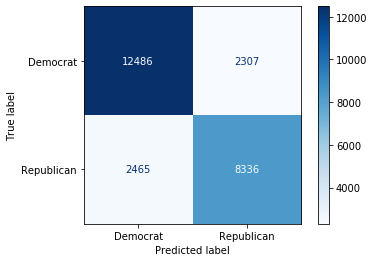

In [16]:
get_stats_pytorch(pytorch_df, "gru.png")

accuracy:  0.85
precision:  0.83
recall:  0.8
f1 score:  0.82 

classification report
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     14793
           1       0.83      0.80      0.82     10801

    accuracy                           0.85     25594
   macro avg       0.84      0.84      0.84     25594
weighted avg       0.85      0.85      0.85     25594



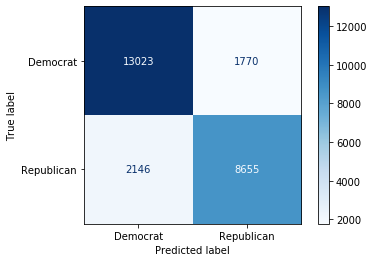

In [19]:
get_stats(mnb_model, y_test, "mnb_confusion_matrix.png")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


accuracy:  0.79
precision:  0.84
recall:  0.62
f1 score:  0.71 

classification report
              precision    recall  f1-score   support

           0       0.77      0.92      0.83     14793
           1       0.84      0.62      0.71     10801

    accuracy                           0.79     25594
   macro avg       0.80      0.77      0.77     25594
weighted avg       0.80      0.79      0.78     25594



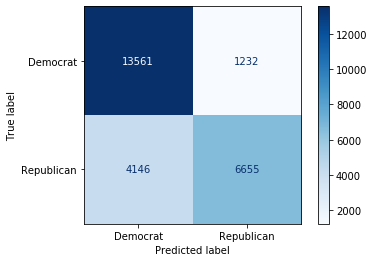

In [20]:
get_stats(rfc_model, y_test, "rfc_confusion_matrix.png")

accuracy:  0.86
precision:  0.85
recall:  0.8
f1 score:  0.82 

classification report
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     14793
           1       0.85      0.80      0.82     10801

    accuracy                           0.86     25594
   macro avg       0.86      0.85      0.85     25594
weighted avg       0.86      0.86      0.86     25594



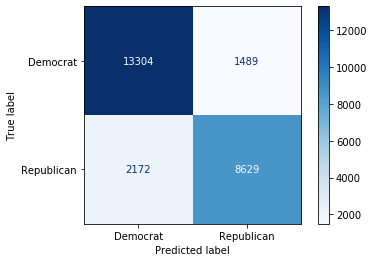

In [21]:
get_stats(svc_model, y_test, "svc_confusion_matrix.png")

# ROC Curves

In [22]:
y_test_strings = le.inverse_transform(y_test)

In [ ]:
y_test_strings

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


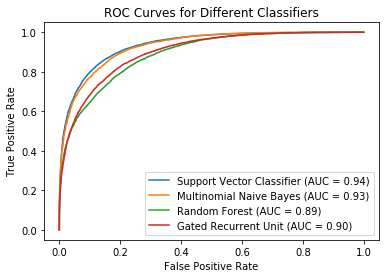

In [26]:
fig, ax = plt.subplots()
metrics.plot_roc_curve(svc_model, X_test, y_test_strings, name="Support Vector Classifier", ax=ax)
metrics.plot_roc_curve(mnb_model, X_test, y_test_strings, name="Multinomial Naive Bayes", ax=ax)
metrics.plot_roc_curve(rfc_model, X_test, y_test_strings, name="Random Forest", ax=ax)

fpr, tpr, thresholds = metrics.roc_curve(pytorch_df["True Labels"].values, pytorch_df["Probability"].values)
auc = metrics.auc(fpr, tpr)

disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name="Gated Recurrent Unit")
disp.plot(ax=ax)
ax.legend()
ax.set(title="ROC Curves for Different Classifiers")

plt.show()


fig.savefig("./Figures/ROC_curves.png")



# Precision Recall Curves

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


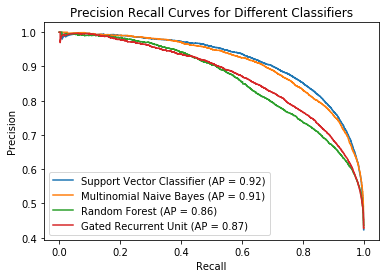

In [27]:
fig, ax = plt.subplots()
metrics.plot_precision_recall_curve(svc_model, X_test, y_test_strings, name="Support Vector Classifier", ax=ax)
metrics.plot_precision_recall_curve(mnb_model, X_test, y_test_strings, name="Multinomial Naive Bayes", ax=ax)
metrics.plot_precision_recall_curve(rfc_model, X_test, y_test_strings, name="Random Forest", ax=ax)

precision, recall, thresholds = metrics.precision_recall_curve(pytorch_df["True Labels"].values, pytorch_df["Probability"].values)
ap = metrics.average_precision_score(pytorch_df["True Labels"].values, pytorch_df["Probability"].values)

disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap, estimator_name="Gated Recurrent Unit")
disp.plot(ax=ax)
ax.legend()

ax.set(title="Precision Recall Curves for Different Classifiers")
fig.savefig("./Figures/Precision_recall_curves.png")

# Example Code

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection, svm
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [ ]:
X, y = datasets.make_classification(random_state=0)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=0)

svc_clf = svm.SVC(random_state=0)
svc_clf.fit(X_train, y_train)

forest_clf = RandomForestClassifier(random_state=0)
forest_clf.fit(X_train, y_train)
y_score = forest_clf.predict_proba(X_test)
y_score = y_score[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots()
metrics.plot_roc_curve(svc_clf, X_test, y_test, name="SVM", ax=ax)
#ax.plot(fpr, tpr, label="Random Forest (AUC= %.02f)" % auc)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name="Random Forest")
disp.plot(ax=ax)
ax.set(title="ROC curves")
ax.legend()

plt.show()


In [ ]:
metrics.plot_roc_curve(forest_clf, X_test, y_test, name="Random Forest")
plt.show()

In [ ]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_score)
ap = metrics.average_precision_score(y_test, y_score)

fig, ax = plt.subplots()
metrics.plot_precision_recall_curve(svc_clf, X_test, y_test, name="SVM", ax=ax)
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap, estimator_name="Random Forest")
disp.plot(ax=ax)
ax.set(title="Precision Recall Curves")
ax.legend()

plt.show()

In [ ]:
PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap, estimator_name="Random Forest").plot()

In [ ]:
metrics.plot_precision_recall_curve(forest_clf, X_test, y_test)
plt.show()